# PINN: Physics-Informed Neural Network

## Solve
$$ \frac{d^2u(x)}{dx^2} = f(x) $$
$f(x)$: Given function  
$u(0)=u_0$, $u(1)=u_1$: Given boundary condition


### PINNの戦略
- ニューラルネットワークを用いて関数 $u(x)$ を表す。有限個の数値（ニューラルネットワークのハイパーパラメータ $\theta$ ）を用いて表せる連続関数（連続関数全体の一部分）で $u(x)$ を近似的に表現した。
- 様々な位置 ( collocation points $x_\mathrm{col}$ ) で $d^2u(x)/dx^2$ を評価し、与えられた$f(x)$ と一致するか確認。ずれの大きさを $\mathrm{L}(\theta)$ として定義。
- このずれ $\mathrm{L}(\theta)$ が最小（理想的には完全に0。とはいえ、用意したニューラルネットワークで表現できる関数は限られているので、その限られた関数表現の中でなるべく方程式を満たすよう努力）となる $\theta$ が得られれば、その $\theta$ で表されるニューラルネットワークが解 $u(x)$ の良い近似。

In [ ]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from flax import linen as nn
from flax.training.train_state import TrainState
from jax import grad, vmap
import functools
from scipy.stats.qmc import Sobol
from time import time as timer

# --- モデル定義（Multi-Layer Perceptron） ---
class MLP(nn.Module):
    layers: list
    @nn.compact
    def __call__(self, x):  # x: (N, D)
        # 各隠れ層にtanh活性化関数を通す
        for w in self.layers[:-1]:
            x = nn.tanh(nn.Dense(w)(x))
        # 最終層は線形出力（Denseのみ）（多成分出力（ベクトル）も可能だが、今回は1成分出力（スカラー）を想定）
        return nn.Dense(self.layers[-1])(x)  # (N, 1)

# --- Physics-Informed Neural Network クラス ---
class PINN_Poisson:
    def __init__(self, model: nn.Module, lr: float = 1e-3):
        self.model = model
        # 入力形状 (1, D) をもつダミーデータで初期化（ネットワークの構造を決定）
        dummy_x = jnp.zeros((1, model.layers[0]))  # D次元入力
        rng = jax.random.PRNGKey(0)
        params = self.model.init(rng, dummy_x)
        # 最適化アルゴリズム（学習率指定）
        tx = optax.adam(lr)
        # flax.training.TrainState によって状態を一括管理（パラメータ・オプティマイザなど）
        self.state = TrainState.create(
            apply_fn=self.model.apply,
            params=params,
            tx=tx
        )
        self.history = {"epoch": [], "loss": []}

    @functools.partial(jax.jit, static_argnums=(0,))
    def loss_fn(self, params, x_col, f_col, x_obs, u_obs):
        # --- PDE項（Poisson方程式の残差） ---
        u = lambda x: self.model.apply(params, x[None, :])[0, 0]  # スカラー出力 u(x)
        dudx = grad(u)  # 一階微分 du/dx
        d2udx2 = grad(lambda x: dudx(x)[0])  # 二階微分 d²u/dx²
        local_pde = lambda xi: d2udx2(xi)  # PDE残差項の定義
        local_pde_val = vmap(local_pde)(x_col)  # collocation点全体に適用（ベクトル化）（shape: (N_col,1)）
        residual = local_pde_val - f_col  # Poisson方程式残差項：d²u/dx² - f(x)
        loss_pde = jnp.mean(residual**2)  # PDE損失（平均二乗誤差）

        # --- データ項（観測値とNN出力の誤差） ---
        u_pred = self.model.apply(params, x_obs)[:,0]  # 観測点におけるNN出力（shape: (N_obs,)）
        loss_data = jnp.mean((u_pred - u_obs)**2)  # データ損失（平均二乗誤差）

        # --- 全体損失（同等重みで和を取る） ---
        return loss_pde + loss_data

    @functools.partial(jax.jit, static_argnums=(0,))
    def train_step(self, state, x_col, f_col, x_obs, u_obs):
        # 損失とその勾配を計算し、パラメータを1ステップ更新
        loss, grads = jax.value_and_grad(self.loss_fn)(state.params, x_col, f_col, x_obs, u_obs)
        return state.apply_gradients(grads=grads), loss

    def train(self, x_col, f_col, x_obs, u_obs, n_epochs=1000, verbose=True):
        # エポック数分の訓練ループ
        for epoch in range(n_epochs + 1):
            self.state, loss = self.train_step(self.state, x_col, f_col, x_obs, u_obs)
            if epoch % (n_epochs//10) == 0:  # ログ出力の間隔
                self.history["epoch"].append(epoch)
                self.history["loss"].append(loss)
                if verbose:
                    print(f"[Epoch {epoch}] Loss = {loss:.2e}")

    def predict(self, x):  # x: (N,D)
        # 学習済みモデルで推論（観測点以外でも u(x) を得られる）
        return self.model.apply(self.state.params, x)[:,0]

[Epoch 0] Loss = 2.78e-01
[Epoch 150] Loss = 4.46e-02
[Epoch 300] Loss = 4.16e-02
[Epoch 450] Loss = 3.71e-02
[Epoch 600] Loss = 2.58e-02
[Epoch 750] Loss = 5.29e-03
[Epoch 900] Loss = 4.22e-04
[Epoch 1050] Loss = 1.32e-04
[Epoch 1200] Loss = 8.26e-04
[Epoch 1350] Loss = 4.07e-05
[Epoch 1500] Loss = 3.18e-05
Elapsed time [sec] = 2.4700210094451904


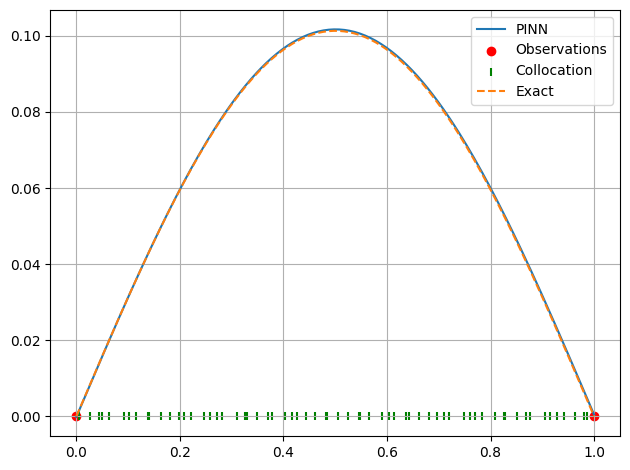

In [ ]:
# --- 問題定義 ---
D = 1  # 入力の次元数（ここでは1次元のPoisson方程式を対象）
f_fn = lambda x: -jnp.sin(jnp.pi * x[:, 0])  # 右辺関数 f(x)（JAX配列対応）
x_obs = jnp.array([[0.0], [1.0]])  # 観測点（境界条件などに対応）
u_obs = jnp.array([0.0, 0.0])      # 観測値（境界値）

# --- PINNモデルの作成 ---
model = MLP([D, 64, 64, 1])        # MLP: D次元→スカラー出力（64ユニット×2層）
solver = PINN_Poisson(model)      # PINNクラスにモデルを渡してインスタンス化

# --- PDE評価位置 (Collocation points)の選定 ---
sampler = Sobol(d=D, scramble=True, seed=0)  # Sobol点列（低偏差系列）でほぼ均質な乱数配置
x_col = jnp.array(sampler.random_base2(m=6))  # 2^6 = 64個のCollocation点
f_col = f_fn(x_col).reshape(-1, 1)            # f(x)をCollocation点で評価（(64,1)）

# --- PINNの学習（NNモデルの関数がPDEを満たすように係数調整）---
t0 = timer()
solver.train(x_col, f_col, x_obs, u_obs, n_epochs=1500)  # PDE項・観測誤差を最小化
t1 = timer(); print("Elapsed time [sec] =", t1-t0)       # 実行時間を出力

# --- 予測結果 ---
x_plot = jnp.linspace(0, 1, 200).reshape(-1, D)  # 可視化用の均等点（200点）
u_pred = solver.predict(x_plot)                 # 学習済みモデルで予測

# --- 可視化 ---
plt.plot(x_plot[:, 0], u_pred, label="PINN")                    # PINNによる予測解
plt.scatter(x_obs[:, 0], u_obs, c="red", label="Observations")  # 観測点（赤）
plt.scatter(x_col, jnp.zeros_like(x_col), marker="|", c="green", label="Collocation")  # Collocation点（緑の縦棒）
u_exact = lambda x: jnp.sin(jnp.pi * x[:, 0]) / (jnp.pi ** 2)   # Poisson方程式の解析解
plt.plot(x_plot[:, 0], u_exact(x_plot), '--', label="Exact")    # 解析解（点線）
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

[Epoch 0] Loss = 1.26e+00
[Epoch 800] Loss = 4.75e-03
[Epoch 1600] Loss = 2.81e-03
[Epoch 2400] Loss = 2.09e-03
[Epoch 3200] Loss = 1.69e-03
[Epoch 4000] Loss = 1.38e-03
[Epoch 4800] Loss = 1.02e-03
[Epoch 5600] Loss = 6.70e-04
[Epoch 6400] Loss = 1.13e-03
[Epoch 7200] Loss = 2.66e-04
[Epoch 8000] Loss = 1.65e-04


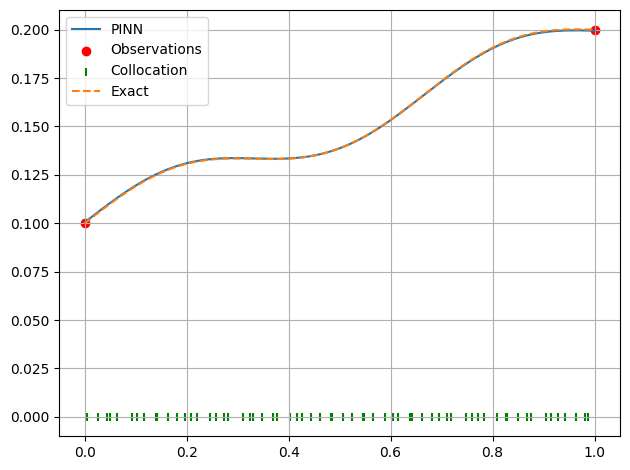

In [ ]:
# --- 問題定義 ---
D = 1
f_fn = lambda x: -jnp.sin(3*jnp.pi * x[:, 0])
x_obs = jnp.array([[0.0], [1.0]])
u_obs = jnp.array([0.1, 0.2])

# --- PINNモデルの作成 ---
model = MLP([D, 64, 64, 1])
solver = PINN_Poisson(model)

# --- PDE評価位置 (Collocation points)の選定 ---
sampler = Sobol(d=D, scramble=True, seed=0)
x_col = jnp.array(sampler.random_base2(m=6))
f_col = f_fn(x_col).reshape(-1, 1)

# --- PINNの学習（NNモデルの関数がPDEを満たすように係数調整）---
solver.train(x_col, f_col, x_obs, u_obs, n_epochs=8000)

# --- 予測結果 ---
x_plot = jnp.linspace(0, 1, 200).reshape(-1, D)
u_pred = solver.predict(x_plot)

# --- 可視化 ---
plt.plot(x_plot[:, 0], u_pred, label="PINN")                    # PINNによる予測解
plt.scatter(x_obs[:, 0], u_obs, c="red", label="Observations")  # 観測点（赤）
plt.scatter(x_col, jnp.zeros_like(x_col), marker="|", c="green", label="Collocation")  # Collocation点（緑の縦棒）
u_exact = lambda x: jnp.sin(3*jnp.pi * x[:, 0]) / ((3*jnp.pi) ** 2) + 0.1 + 0.1*x[:,0]   # Poisson方程式の解析解
plt.plot(x_plot[:, 0], u_exact(x_plot), '--', label="Exact")    # 解析解（点線）
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()